In [1]:
import geopandas as gpd

roads = gpd.read_file("C:/Users/omair/Downloads/texas-251124-free.shp/gis_osm_roads_free_1.shp")
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4342988,5111,motorway,Sam Rayburn Tollway,SRT,F,112,0,F,F,"LINESTRING (-97.00107 32.98973, -97.0021 32.99..."
1,4343083,5111,motorway,Sam Rayburn Tollway,SRT,F,112,0,F,F,"LINESTRING (-97.00623 32.99057, -97.00568 32.9..."
2,4343084,5111,motorway,Sam Rayburn Tollway,SRT,F,112,1,T,F,"LINESTRING (-96.99295 32.98645, -96.99329 32.9..."
3,4343087,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (-96.99882 32.98826, -96.9981 32.98..."
4,4343088,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (-96.99669 32.98806, -96.99731 32.9..."


In [3]:
roads.shape

(3770917, 11)

In [5]:
roads.columns

Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
       'layer', 'bridge', 'tunnel', 'geometry'],
      dtype='object')

In [7]:
roads['fclass'].value_counts()

fclass
service           1813323
residential        832357
footway            483189
secondary          146779
track              126337
tertiary            84391
primary             50745
unclassified        40700
path                32993
motorway            31029
motorway_link       25680
secondary_link      23476
cycleway            23020
trunk               17893
primary_link         9502
trunk_link           7880
tertiary_link        5500
steps                4682
track_grade5         3550
pedestrian           2198
track_grade3         2026
track_grade4         1581
track_grade2         1265
track_grade1          303
bridleway             295
living_street         153
busway                 48
unknown                22
Name: count, dtype: int64

In [9]:
backbone_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
]

roads_2 = roads[roads["fclass"].isin(backbone_classes)]

In [11]:
roads_2.shape

(402875, 11)

In [15]:
import pandas as pd

In [17]:
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.max_colwidth', None)  # show full column text
pd.set_option('display.width', None)         # no width limit

# Central Austin

In [254]:
import pickle
import networkx as nx

G_austin_dir = pickle.load(open("C:/Users/omair/Downloads/texas-251124-free.shp/austin_central_roads.pkl", "rb"))

# undirected view for structural stuff
G_austin = G_austin_dir.to_directed()

print("Directed?", nx.is_directed(G_austin))
print("# nodes:", G_austin.number_of_nodes())
print("# edges:", G_austin.number_of_edges())

degrees = dict(G_austin.degree())
avg_deg = sum(degrees.values()) / len(degrees)
print("Average degree:", avg_deg)


Directed? True
# nodes: 7373
# edges: 11313
Average degree: 3.068764410687644


In [255]:
# For a directed graph G_austin (nx.DiGraph)

# 1) Use weakly connected components (ignore directions for connectivity)
components = list(nx.weakly_connected_components(G_austin))
print("Number of weakly connected components:", len(components))

# 2) Take the largest one = main road blob
largest_cc = max(components, key=len)
G_main = G_austin.subgraph(largest_cc).copy()

print("# nodes in main component:", G_main.number_of_nodes())
print("# edges in main component:", G_main.number_of_edges())

# 3) Degree on a directed graph = in-degree + out-degree
deg_main = dict(G_main.degree())   # total degree
avg_deg_main = sum(deg_main.values()) / len(deg_main)
print("Average total degree (main component):", avg_deg_main)

out_deg = dict(G_main.out_degree())
in_deg  = dict(G_main.in_degree())

avg_out = sum(out_deg.values()) / len(out_deg)
avg_in  = sum(in_deg.values()) / len(in_deg)

print("Average out-degree (main component):", avg_out)
print("Average in-degree  (main component):", avg_in)



Number of weakly connected components: 1288
# nodes in main component: 4268
# edges in main component: 7792
Average total degree (main component): 3.6513589503280226
Average out-degree (main component): 1.8256794751640113
Average in-degree  (main component): 1.8256794751640113


In [258]:
# degree centrality
deg_cent = nx.degree_centrality(G_main)
top_deg = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:20]
for node, val in top_deg:
    print("node:", node, "degree:", G_main.degree(node), "degree centrality:", val)


node: (-10878132.191169342, 3544006.7039943035) degree: 10 degree centrality: 0.002343566908835247
node: (-10876813.945759367, 3543544.0236157076) degree: 9 degree centrality: 0.0021092102179517225
node: (-10879925.759673053, 3541290.025576082) degree: 9 degree centrality: 0.0021092102179517225
node: (-10882135.451565301, 3543299.298966479) degree: 8 degree centrality: 0.0018748535270681978
node: (-10881424.565297095, 3537896.6672202493) degree: 8 degree centrality: 0.0018748535270681978
node: (-10880833.447669033, 3542081.522911235) degree: 8 degree centrality: 0.0018748535270681978
node: (-10879393.296284692, 3542710.839331587) degree: 8 degree centrality: 0.0018748535270681978
node: (-10878424.0931381, 3537228.8354505794) degree: 8 degree centrality: 0.0018748535270681978
node: (-10884714.401340459, 3542191.3470650944) degree: 8 degree centrality: 0.0018748535270681978
node: (-10884886.523537124, 3542286.886345458) degree: 8 degree centrality: 0.0018748535270681978
node: (-10879386.

In [259]:
bet = nx.betweenness_centrality(
    G_main,
    k=200,
    weight="travel_time_s",
    seed=0
)

top_bet = sorted(bet.items(), key=lambda x: x[1], reverse=True)[:20]
for node, val in top_bet:
    print("node:", node, "betweenness:", val)


node: (-10881308.603783535, 3536841.2034721985) betweenness: 0.15236457880455234
node: (-10881257.942283275, 3537576.292776327) betweenness: 0.15045484865095476
node: (-10880874.157206817, 3537452.1252105352) betweenness: 0.13779365426246257
node: (-10881132.351633763, 3536646.3158207787) betweenness: 0.13281944613372437
node: (-10880524.480422337, 3540849.4639192782) betweenness: 0.1249976416003892
node: (-10880532.239390844, 3540761.425623768) betweenness: 0.11906798222844536
node: (-10880581.487133574, 3539815.0365376514) betweenness: 0.11797654037884478
node: (-10880583.435224662, 3540082.536746914) betweenness: 0.11724617703587899
node: (-10880595.580181107, 3539935.25688497) betweenness: 0.11639154641465575
node: (-10880528.354340617, 3540806.379352495) betweenness: 0.11633175744115455
node: (-10880526.339457832, 3540829.778044249) betweenness: 0.11627196846765334
node: (-10880598.697126849, 3539878.356398018) betweenness: 0.11609142921433595
node: (-10882096.088993357, 3537838.2

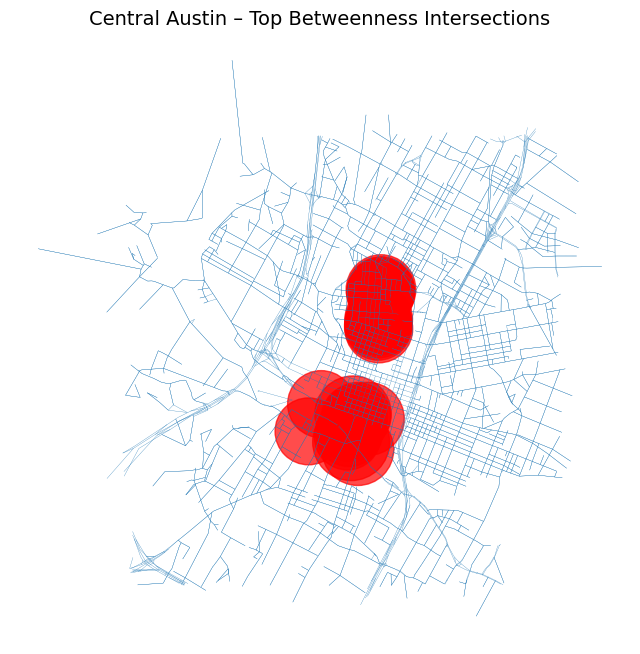

In [260]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt

BBOX_AUSTIN = (-97.8, -97.7, 30.23, 30.32)
lon_min, lon_max, lat_min, lat_max = BBOX_AUSTIN

roads_a = gpd.read_file(
    "C:/Users/omair/Downloads/texas-251124-free.shp/gis_osm_roads_free_1.shp",
    bbox=(lon_min, lat_min, lon_max, lat_max)
)

backbone_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "unclassified", "residential", "living_street",
]

roads_a = roads_a[roads_a["fclass"].isin(backbone_classes)]
roads_3857 = roads_a.to_crs(epsg=3857)

# edges from G_main
edge_records = []
for u, v, data in G_main.edges(data=True):
    edge_records.append({
        "u": u,
        "v": v,
        "highway": data.get("highway"),
        "geometry": LineString([u, v]),
    })

edges_gdf = gpd.GeoDataFrame(edge_records, geometry="geometry", crs="EPSG:3857")

# nodes (top betweenness)
node_records = []
for (x, y), val in top_bet:
    node_records.append({
        "x": x,
        "y": y,
        "betweenness": val,
        "geometry": Point(x, y),
    })
nodes_top_bet = gpd.GeoDataFrame(node_records, geometry="geometry", crs="EPSG:3857")

fig, ax = plt.subplots(figsize=(8, 8))
edges_gdf.plot(ax=ax, linewidth=0.2)
nodes_top_bet.plot(
    ax=ax,
    markersize=20 + 20000 * nodes_top_bet["betweenness"],
    color="red",
    alpha=0.7,
)
ax.set_title("Central Austin – Top Betweenness Intersections", fontsize=14)
ax.set_axis_off()
plt.show()


In [341]:
print("Central Austin (G_main) summary:")
print("  # nodes:", G_main.number_of_nodes())
print("  # edges:", G_main.number_of_edges())


Central Austin (G_main) summary:
  # nodes: 4268
  # edges: 7792


6789 road segments in Central Austin


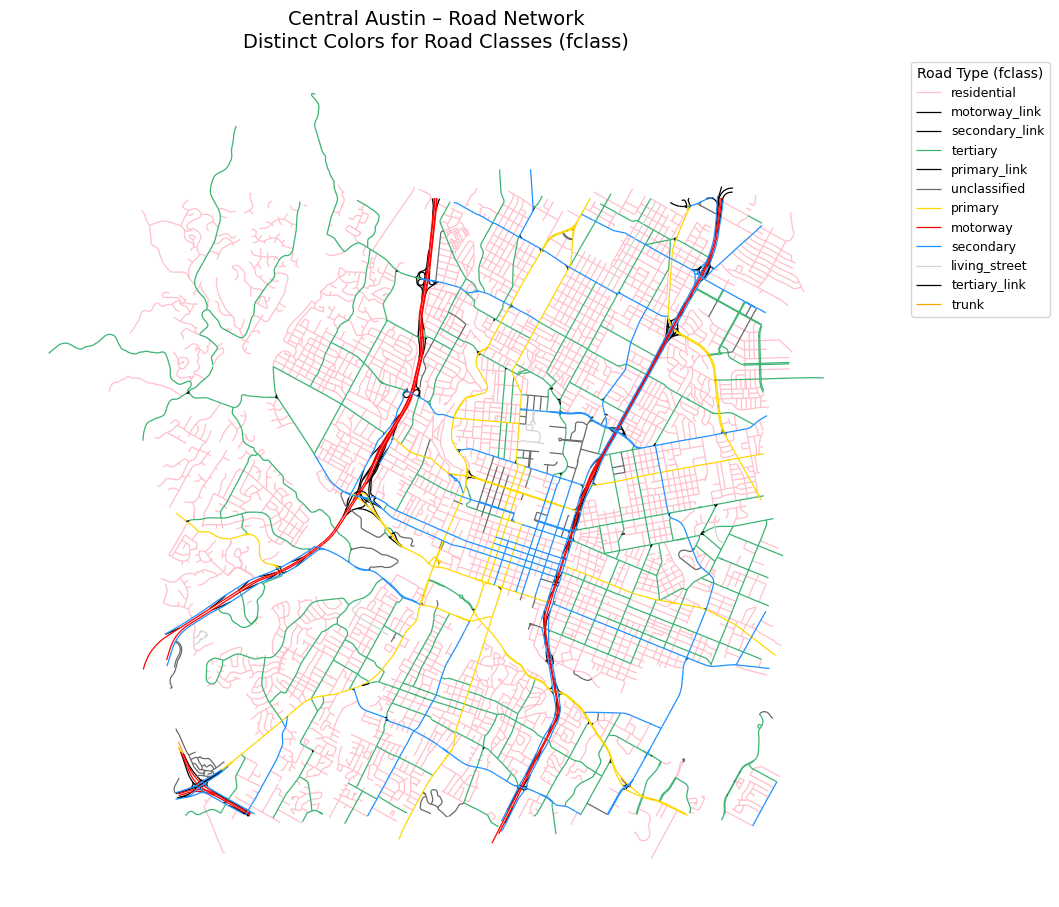

In [333]:
from matplotlib import pyplot as plt

# --- Central Austin bounding box (you already defined this) ---
austin_bbox = BBOX_AUSTIN  # (-97.8, -97.7, 30.23, 30.32)

# roads_a is already filtered to that bbox and backbone_classes.
print(len(roads_a), "road segments in Central Austin")

# Project to 3857 for plotting
austin_proj = roads_a.to_crs(epsg=3857)

# CUSTOM color palette (same style as Leander)
color_map = {
    "motorway": "red",
    "trunk": "orange",
    "primary": "gold",
    "secondary": "dodgerblue",
    "tertiary": "mediumseagreen",
    
    # Minor roads
    "residential": "pink",
    "unclassified": "dimgray",
    "living_street": "lightgray",
    "service": "lightgray",
    
    # Tracks (may or may not appear in Austin bbox)
    "track": "saddlebrown",
    "track_grade1": "saddlebrown",
    "track_grade2": "sienna",
    "track_grade3": "peru",
    "track_grade4": "tan",
    "track_grade5": "wheat",

    # Walking/bike
    "cycleway": "purple",
    "footway": "forestgreen",
    "path": "darkgreen",
    "bridleway": "darkcyan",
}

# fallback color if type not in dict
default_color = "black"

# Determine unique road classes actually present in Austin
road_types = austin_proj["fclass"].unique()

# Plot
fig, ax = plt.subplots(figsize=(11, 11))

for rtype in road_types:
    subset = austin_proj[austin_proj["fclass"] == rtype]
    clr = color_map.get(rtype, default_color)
    subset.plot(ax=ax, color=clr, linewidth=0.9, label=rtype)

ax.set_title(
    "Central Austin – Road Network\nDistinct Colors for Road Classes (fclass)",
    fontsize=14
)
ax.set_axis_off()

# Legend outside the map
ax.legend(
    title="Road Type (fclass)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=9
)

plt.show()


In [261]:
# name column (could be 'name' or 'name_left')
name_col = "name" if "name" in roads_3857.columns else "name_left"

def get_street_names(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    names = sorted(set(nearby[name_col].dropna()))
    if not names:
        return "Unnamed road"
    return " & ".join(names[:4])

top_node, top_bet_val = top_bet[0]
top_point = Point(top_node)

street_names = get_street_names(top_point, roads_3857, radius=30)
print("Most critical intersection in central Austin:")
print("  Coordinates:", top_node)
print("  Streets:", street_names)
print("  Betweenness:", top_bet_val)


Most critical intersection in central Austin:
  Coordinates: (-10881308.603783535, 3536841.2034721985)
  Streets: Barton Springs Road & East Riverside Drive
  Betweenness: 0.15236457880455234


In [263]:
import random

def approx_global_efficiency(G, weight=None, k_sources=200, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)
    if n <= 1:
        return 0.0

    k_sources = min(k_sources, n)
    sources = rng.sample(nodes, k_sources)

    total_inv = 0.0
    count = 0

    for s in sources:
        if weight is None:
            lengths = nx.single_source_shortest_path_length(G, s)
        else:
            lengths = nx.single_source_dijkstra_path_length(G, s, weight=weight)
        for t, d in lengths.items():
            if t == s or d <= 0:
                continue
            total_inv += 1.0 / d
            count += 1

    if count == 0:
        return 0.0

    return total_inv / count

base_eff = approx_global_efficiency(G_main, weight="travel_time_s", k_sources=200, seed=0)
print("Baseline approximate global efficiency (Austin):", base_eff)


Baseline approximate global efficiency (Austin): 0.004258743128767823


In [264]:
# Closeness centrality for Austin main component (using travel time as distance)
closeness = nx.closeness_centrality(G_main, distance="travel_time_s")


In [384]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx

# Treat G_main as the Austin main component
G_austin_main = G_main


In [386]:
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ==========================
# Overall centrality score for AUSTIN (G_main)
# ==========================

print("Computing degree centrality (Austin)...")
deg_austin = nx.degree_centrality(G_main)

print("Computing closeness centrality (travel time, Austin)...")
clo_austin = nx.closeness_centrality(
    G_main,
    distance="travel_time_s"
)

print("Computing betweenness centrality (sampled, travel time, Austin)...")
btw_austin = nx.betweenness_centrality(
    G_main,
    k=min(500, G_main.number_of_nodes()),
    weight="travel_time_s",
    seed=0
)

# Combine into one table
centrality_df_austin = pd.DataFrame({
    "node": list(G_main.nodes())
})
centrality_df_austin["degree"] = centrality_df_austin["node"].map(deg_austin)
centrality_df_austin["closeness"] = centrality_df_austin["node"].map(clo_austin)
centrality_df_austin["betweenness"] = centrality_df_austin["node"].map(btw_austin)

# Normalized z-scores
for col in ["degree", "closeness", "betweenness"]:
    mu = centrality_df_austin[col].mean()
    sd = centrality_df_austin[col].std() if centrality_df_austin[col].std() > 0 else 1.0
    centrality_df_austin[col + "_z"] = (centrality_df_austin[col] - mu) / sd

centrality_df_austin["centrality_score"] = (
    centrality_df_austin["degree_z"] +
    centrality_df_austin["closeness_z"] +
    centrality_df_austin["betweenness_z"]
)

centrality_df_austin.sort_values("centrality_score", ascending=False, inplace=True)

# Small dicts for quick lookup in loops
centrality_score_dict = dict(
    zip(centrality_df_austin["node"], centrality_df_austin["centrality_score"])
)

# (optional) hubs table with names
top_k = 50
top_hubs_austin = centrality_df_austin.head(top_k).copy()

gdf_hubs_austin = gpd.GeoDataFrame(
    top_hubs_austin,
    geometry=[Point(xy) for xy in top_hubs_austin["node"]],
    crs="EPSG:3857"
)

gdf_hubs_austin = gpd.sjoin_nearest(
    gdf_hubs_austin,
    roads_3857[[road_name_col, "geometry"]],
    how="left",
    distance_col="dist_nearest",
    max_distance=50
)
gdf_hubs_austin["road_name"] = gdf_hubs_austin[road_name_col].fillna("Unnamed road")
gdf_hubs_austin.drop(columns=[road_name_col], inplace=True)

gdf_hubs_austin["intersection_names"] = gdf_hubs_austin.geometry.apply(
    lambda p: get_intersection_names(p, roads_3857, radius=30)
)

gdf_hubs_unique_austin = (
    gdf_hubs_austin
    .sort_values("centrality_score", ascending=False)
    .drop_duplicates(subset="intersection_names")
)

central_hub_table_austin = gdf_hubs_unique_austin[
    ["intersection_names", "road_name", "degree", "closeness",
     "betweenness", "centrality_score"]
].sort_values("centrality_score", ascending=False)

central_hub_table_austin.head(10)


Computing degree centrality (Austin)...
Computing closeness centrality (travel time, Austin)...
Computing betweenness centrality (sampled, travel time, Austin)...


,intersection_names,road_name,degree,closeness,betweenness,centrality_score
2546,Barton Springs Road & East Riverside Drive,East Riverside Drive,0.001875,0.003700,0.157227,10.300216
249,Congress Avenue & East Cesar Chavez Street & West Cesar Chavez Street,West Cesar Chavez Street,0.001875,0.003934,0.145935,10.047247
1597,Guadalupe Street & South 1st Street & West Cesar Chavez Street,West Cesar Chavez Street,0.001406,0.003938,0.148236,9.004733
3147,Barton Springs Road & South 1st Street,Barton Springs Road,0.001875,0.003644,0.124416,8.724419
2148,Barton Springs Road & South Lamar Boulevard,South Lamar Boulevard,0.001875,0.003310,0.130064,8.602779
2535,East Riverside Drive & South Congress Avenue,South Congress Avenue,0.001875,0.003641,0.121722,8.597229
1669,Guadalupe Street & West 21st Street,Guadalupe Street,0.001875,0.003794,0.115808,8.499891
2428,East Riverside Drive & South 1st Street,East Riverside Drive,0.001875,0.003697,0.116062,8.401202
362,Guadalupe Street & West Martin Luther King Jr Boulevard,Guadalupe Street,0.001640,0.003866,0.122481,8.313074
1706,Guadalupe Street & West 24th Street,West 24th Street,0.001875,0.003739,0.108560,8.103212


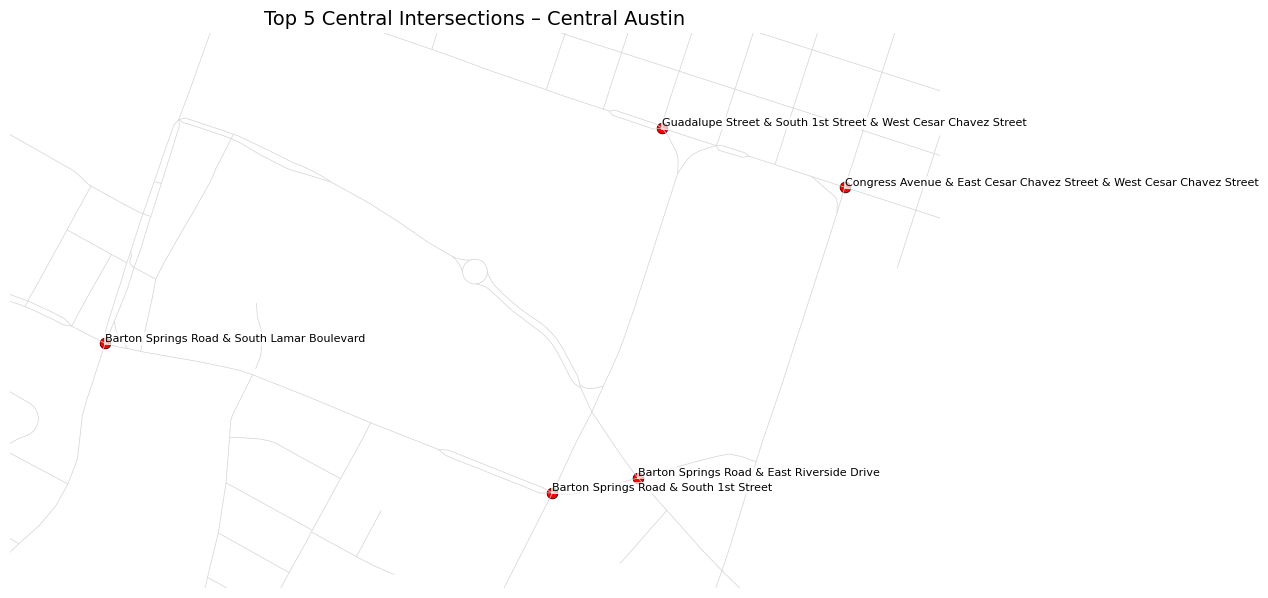

In [387]:
import matplotlib.pyplot as plt

# Sort hubs by overall centrality score and take top 5
gdf_hubs_sorted_austin = gdf_hubs_unique_austin.sort_values(
    "centrality_score",
    ascending=False
)
top5_austin = gdf_hubs_sorted_austin.head(5).copy()

fig, ax = plt.subplots(figsize=(12, 12))

# 1) Background: central Austin road network
roads_3857.plot(ax=ax, color="lightgray", linewidth=0.5)

# 2) Overlay: top 5 central intersections (big red points)
top5_austin.plot(
    ax=ax,
    color="red",
    markersize=60,
    edgecolor="black",
    linewidth=0.5
)

# 3) Label each point with its intersection name
for _, row in top5_austin.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    label = row["intersection_names"]
    ax.text(
        x, y,
        label,
        fontsize=8,
        ha="left",
        va="bottom",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0),
    )

# 4) Zoom in around the top hubs
minx, miny, maxx, maxy = top5_austin.total_bounds
pad = 200  # meters of padding around the hubs
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Top 5 Central Intersections – Central Austin", fontsize=14)
ax.set_axis_off()

plt.show()


## Question 2

### Node Closure

In [390]:
if "name" in roads_3857.columns:
    road_name_col = "name"
elif "name_left" in roads_3857.columns:
    road_name_col = "name_left"
else:
    road_name_col = None


In [391]:
def get_intersection_names(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    if road_name_col is None:
        return "Unknown roads"
    names = sorted(set(nearby[road_name_col].dropna()))
    if not names:
        return "Unnamed road"
    return " & ".join(names[:4])

def get_main_road_name(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    if nearby.empty:
        return "Unknown"
    if road_name_col is not None:
        named = nearby[nearby[road_name_col].notna()]
        if not named.empty:
            return str(named.iloc[0][road_name_col])
    if "fclass" in nearby.columns:
        return str(nearby.iloc[0]["fclass"])
    return "Unknown"


In [392]:
# ==========================
# Node closures: top-10 betweenness intersections
# ==========================

k_nodes = 10
top_bet_nodes = sorted(
    btw_austin.items(),
    key=lambda x: x[1],
    reverse=True
)[:k_nodes]

rows = []
for (node, bval) in top_bet_nodes:
    print("Evaluating node closure:", node, "betweenness:", bval)
    
    # Simulate closing this intersection
    G_closed = G_main.copy()
    if node in G_closed:
        G_closed.remove_node(node)

    # Efficiency after closure
    eff_closed = approx_global_efficiency(
        G_closed,
        weight="travel_time_s",
        k_sources=200,
        seed=0
    )
    eff_drop_pct = 0.0
    if base_eff > 0:
        eff_drop_pct = 100.0 * (base_eff - eff_closed) / base_eff

    # Geometry + names
    pt = Point(node)
    intersection_names = get_intersection_names(pt, roads_3857, radius=30)
    main_road = get_main_road_name(pt, roads_3857, radius=30)

    rows.append({
        "node": node,
        "intersection_names": intersection_names,
        "road_name": main_road,
        "degree": deg_austin[node],
        "closeness": clo_austin[node],
        "betweenness": btw_austin[node],
        "centrality_score": centrality_score_dict[node],
        "eff_drop_pct": eff_drop_pct,
        "geometry": pt,
    })

node_closures_austin = pd.DataFrame(rows)

node_closures_austin_sorted = node_closures_austin.sort_values(
    "eff_drop_pct",
    ascending=False
)

# Top 10 most impactful node closures (with centrality scores)
top_nodes_gdf = gpd.GeoDataFrame(
    node_closures_austin_sorted.head(10),
    geometry="geometry",
    crs="EPSG:3857"
)

top_nodes_gdf[
    ["intersection_names",
     "road_name",
     "degree",
     "closeness",
     "betweenness",
     "centrality_score",
     "eff_drop_pct"]
]


Evaluating node closure: (-10881308.603783535, 3536841.2034721985) betweenness: 0.15722671191629609
Evaluating node closure: (-10881257.942283275, 3537576.292776327) betweenness: 0.14823632603421563
Evaluating node closure: (-10880874.157206817, 3537452.1252105352) betweenness: 0.14593480225426306
Evaluating node closure: (-10882428.700499898, 3537123.951842634) betweenness: 0.13006376062172534
Evaluating node closure: (-10880524.480422337, 3540849.4639192782) betweenness: 0.12627571883393868
Evaluating node closure: (-10881488.58513625, 3536809.9248459) betweenness: 0.12441639899133232
Evaluating node closure: (-10880581.487133574, 3539815.0365376514) betweenness: 0.122481111982395
Evaluating node closure: (-10881132.351633763, 3536646.3158207787) betweenness: 0.12172237818533647
Evaluating node closure: (-10880532.239390844, 3540761.425623768) betweenness: 0.11968955308629523
Evaluating node closure: (-10880595.580181107, 3539935.25688497) betweenness: 0.1176149929390845


,intersection_names,road_name,degree,closeness,betweenness,centrality_score,eff_drop_pct
2,Congress Avenue & East Cesar Chavez Street & West Cesar Chavez Street,East Cesar Chavez Street,0.001875,0.003934,0.145935,10.047247,4.622795
6,Guadalupe Street & West Martin Luther King Jr Boulevard,Guadalupe Street,0.001640,0.003866,0.122481,8.313074,4.037031
8,Guadalupe Street & West 25th Street,West 25th Street,0.001406,0.003712,0.119690,7.431878,2.699677
3,Barton Springs Road & South Lamar Boulevard,South Lamar Boulevard,0.001875,0.003310,0.130064,8.602779,2.617376
7,East Riverside Drive & South Congress Avenue,East Riverside Drive,0.001875,0.003641,0.121722,8.597229,2.370894
1,Guadalupe Street & South 1st Street & West Cesar Chavez Street,West Cesar Chavez Street,0.001406,0.003938,0.148236,9.004733,2.320631
9,Guadalupe Street & West 20th Street,West 20th Street,0.001406,0.003828,0.117615,7.468423,2.273862
4,Guadalupe Street & West Dean Keeton Street,West Dean Keeton Street,0.001172,0.003695,0.126276,7.138367,1.768320
0,Barton Springs Road & East Riverside Drive,Barton Springs Road,0.001875,0.003700,0.157227,10.300216,0.774009
5,Barton Springs Road & South 1st Street,South 1st Street,0.001875,0.003644,0.124416,8.724419,-0.118885


In [393]:
node_closures_austin_sorted = node_closures_austin.sort_values(
    "eff_drop_pct",
    ascending=False
)

# Top 10 most impactful node closures
top_nodes_gdf = gpd.GeoDataFrame(
    node_closures_austin_sorted.head(10),
    geometry="geometry",
    crs="EPSG:3857"
)

top_nodes_gdf[["intersection_names", "road_name", "betweenness", "eff_drop_pct"]]


,intersection_names,road_name,betweenness,eff_drop_pct
2,Congress Avenue & East Cesar Chavez Street & West Cesar Chavez Street,East Cesar Chavez Street,0.145935,4.622795
6,Guadalupe Street & West Martin Luther King Jr Boulevard,Guadalupe Street,0.122481,4.037031
8,Guadalupe Street & West 25th Street,West 25th Street,0.119690,2.699677
3,Barton Springs Road & South Lamar Boulevard,South Lamar Boulevard,0.130064,2.617376
7,East Riverside Drive & South Congress Avenue,East Riverside Drive,0.121722,2.370894
1,Guadalupe Street & South 1st Street & West Cesar Chavez Street,West Cesar Chavez Street,0.148236,2.320631
9,Guadalupe Street & West 20th Street,West 20th Street,0.117615,2.273862
4,Guadalupe Street & West Dean Keeton Street,West Dean Keeton Street,0.126276,1.768320
0,Barton Springs Road & East Riverside Drive,Barton Springs Road,0.157227,0.774009
5,Barton Springs Road & South 1st Street,South 1st Street,0.124416,-0.118885


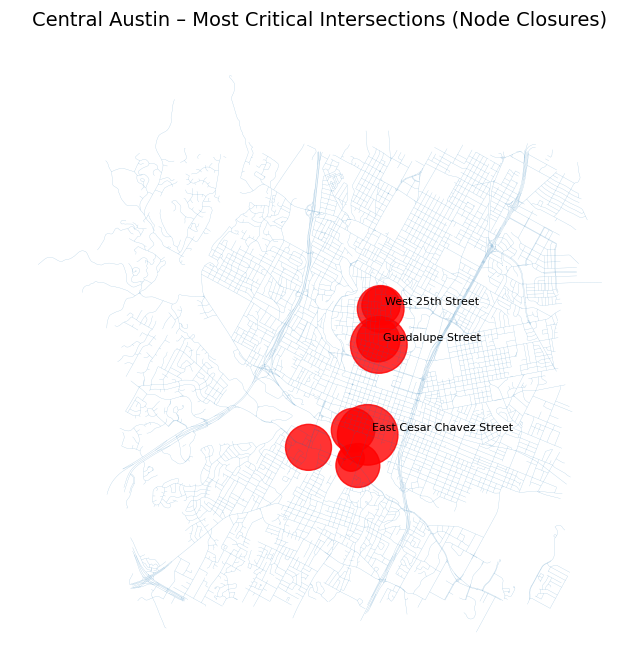

In [394]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# 1) background road network (thin, light)
roads_3857.plot(ax=ax, linewidth=0.2, alpha=0.4)

# 2) overlay the top critical intersections (bigger points)
# size them by efficiency drop or betweenness
sizes = 50 + 400 * top_nodes_gdf["eff_drop_pct"]  # tweak the scaling if needed

top_nodes_gdf.plot(
    ax=ax,
    markersize=sizes,
    color="red",
    alpha=0.8,
)

for _, row in top_nodes_gdf.head(3).iterrows():
    x, y = row.geometry.x, row.geometry.y
    ax.annotate(
        row["road_name"],
        xy=(x, y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
    )


ax.set_title("Central Austin – Most Critical Intersections (Node Closures)", fontsize=14)
ax.set_axis_off()

plt.show()


### Edge Closure

In [402]:
import random
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ==========================
# Edge betweenness for Austin
# ==========================

class SeqRandom(random.Random):
    def sample(self, population, k, counts=None):
        return super().sample(list(population), k, counts=counts)

rng = SeqRandom(42)

print("Computing edge betweenness (Austin)...")
edge_btw = nx.edge_betweenness_centrality(
    G_main,
    k=min(500, G_main.number_of_nodes()),
    weight="travel_time_s",
    seed=rng
)

# quick sanity check: top few edges by betweenness
sorted(list(edge_btw.items()), key=lambda x: x[1], reverse=True)[:5]


Computing edge betweenness (Austin)...


[(((-10880911.660743266, 3538658.8473858805),
   (-10880935.316135058, 3538585.286420385)),
  0.009320181098199407),
 (((-10880935.316135058, 3538585.286420385),
   (-10880949.988043945, 3538539.876561786)),
  0.009294208578333449),
 (((-10880522.933081415, 3540864.263798352),
   (-10880524.480422337, 3540849.4639192782)),
  0.008518602144704164),
 (((-10879544.902299203, 3538429.4911985276),
   (-10879525.94458992, 3538485.5989117017)),
  0.008508443759555746),
 (((-10880778.83432685, 3539078.2316858466),
   (-10880800.84219018, 3539009.2184502124)),
  0.0083609549892387)]

In [404]:
# ==========================
# Edge closure impact helper
# ==========================

def edge_closure_impact_with_roadname(G, edge_btw, base_eff, roads_gdf, k=10):
    """
    For the top-k edges by edge betweenness:
      - remove the edge (simulate closure),
      - recompute approximate global efficiency,
      - record efficiency drop and nearest road name + intersections.
    Returns a GeoDataFrame with midpoint geometry.
    """
    results = []
    # Top-k edges by edge betweenness (highest first)
    top_edges = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k]

    for (u, v), bscore in top_edges:
        print("Evaluating edge closure:", (u, v), "betweenness:", bscore)

        # 1) simulate closing this road segment
        G_tmp = G.copy()
        if G_tmp.has_edge(u, v):
            G_tmp.remove_edge(u, v)
        else:
            # Edge missing for some reason; record placeholder
            results.append(((u, v), None, None, bscore, None, None, "Unknown road"))
            continue

        # 2) efficiency after closure
        eff_closed = approx_global_efficiency(
            G_tmp,
            weight="travel_time_s",
            k_sources=200,
            seed=0
        )

        eff_drop_pct = 0.0
        if base_eff > 0:
            eff_drop_pct = 100.0 * (base_eff - eff_closed) / base_eff

        # 3) midpoint for nearest-road lookup
        midpoint = Point((u[0] + v[0]) / 2.0, (u[1] + v[1]) / 2.0)
        gdf_mid = gpd.GeoDataFrame(
            {"betweenness": [bscore]},
            geometry=[midpoint],
            crs="EPSG:3857"
        )

        # 4) nearest road name
        if road_name_col is not None:
            match = gpd.sjoin_nearest(
                gdf_mid,
                roads_gdf[[road_name_col, "geometry"]],
                how="left",
                distance_col="dist",
                max_distance=50
            ).iloc[0]
            if pd.notna(match[road_name_col]):
                road_name = match[road_name_col]
            else:
                road_name = "Unnamed road"
        else:
            road_name = "Unknown road"

        # 5) label endpoints as intersections
        pt_u = Point(u)
        pt_v = Point(v)

        from_intersection = get_intersection_names(pt_u, roads_gdf, radius=30)
        to_intersection   = get_intersection_names(pt_v, roads_gdf, radius=30)

        results.append((
            (u, v),
            from_intersection,
            to_intersection,
            bscore,
            eff_closed,
            eff_drop_pct,
            road_name
        ))

    df = pd.DataFrame(
        results,
        columns=[
            "edge",
            "from_intersection",
            "to_intersection",
            "betweenness",
            "efficiency_after",
            "eff_drop_pct",
            "road_name"
        ]
    )

    df_gdf = gpd.GeoDataFrame(
        df,
        geometry=[
            Point((u[0] + v[0]) / 2.0, (u[1] + v[1]) / 2.0)
            for (u, v) in df["edge"]
        ],
        crs="EPSG:3857"
    )
    return df_gdf



In [406]:
# ==========================
# Run edge closure experiment (Austin)
# ==========================

k_edges = 10  # how many critical segments you want to analyze
edge_impact_austin = edge_closure_impact_with_roadname(
    G_main, edge_btw, base_eff, roads_3857, k=k_edges
)

# Table of most critical road segments
edge_impact_austin[
    ["road_name", "from_intersection", "to_intersection", "betweenness", "eff_drop_pct"]
].head(10)


Evaluating edge closure: ((-10880911.660743266, 3538658.8473858805), (-10880935.316135058, 3538585.286420385)) betweenness: 0.009320181098199407
Evaluating edge closure: ((-10880935.316135058, 3538585.286420385), (-10880949.988043945, 3538539.876561786)) betweenness: 0.009294208578333449
Evaluating edge closure: ((-10880522.933081415, 3540864.263798352), (-10880524.480422337, 3540849.4639192782)) betweenness: 0.008518602144704164
Evaluating edge closure: ((-10879544.902299203, 3538429.4911985276), (-10879525.94458992, 3538485.5989117017)) betweenness: 0.008508443759555746
Evaluating edge closure: ((-10880778.83432685, 3539078.2316858466), (-10880800.84219018, 3539009.2184502124)) betweenness: 0.0083609549892387
Evaluating edge closure: ((-10880800.84219018, 3539009.2184502124), (-10880810.549249778, 3538978.785202377)) betweenness: 0.008334982469372743
Evaluating edge closure: ((-10880828.883569911, 3538921.2960817916), (-10880872.55420615, 3538779.5465569096)) betweenness: 0.008328722

,road_name,from_intersection,to_intersection,betweenness,eff_drop_pct
0,Guadalupe Street,Guadalupe Street & West 10th Street,Guadalupe Street,0.009320,0.205267
1,Guadalupe Street,Guadalupe Street,Guadalupe Street & West 9th Street,0.009294,0.193635
2,Guadalupe Street,Guadalupe Street & West Dean Keeton Street,Guadalupe Street & West Dean Keeton Street,0.008519,0.109460
3,Purple Heart Trail,Purple Heart Trail,Purple Heart Trail,0.008508,0.653092
4,Guadalupe Street,Guadalupe Street & West 13th Street,Guadalupe Street,0.008361,0.182935
5,Guadalupe Street,Guadalupe Street,Guadalupe Street,0.008335,0.174280
6,Guadalupe Street,Guadalupe Street & West 12th Street,Guadalupe Street & West 11th Street,0.008329,0.170349
7,Guadalupe Street,Guadalupe Street,Guadalupe Street & West 12th Street,0.008309,0.166078
8,Guadalupe Street,Guadalupe Street,Guadalupe Street & West 14th Street,0.008245,0.257446
9,Guadalupe Street,Guadalupe Street & West 14th Street,Guadalupe Street,0.008175,0.284430


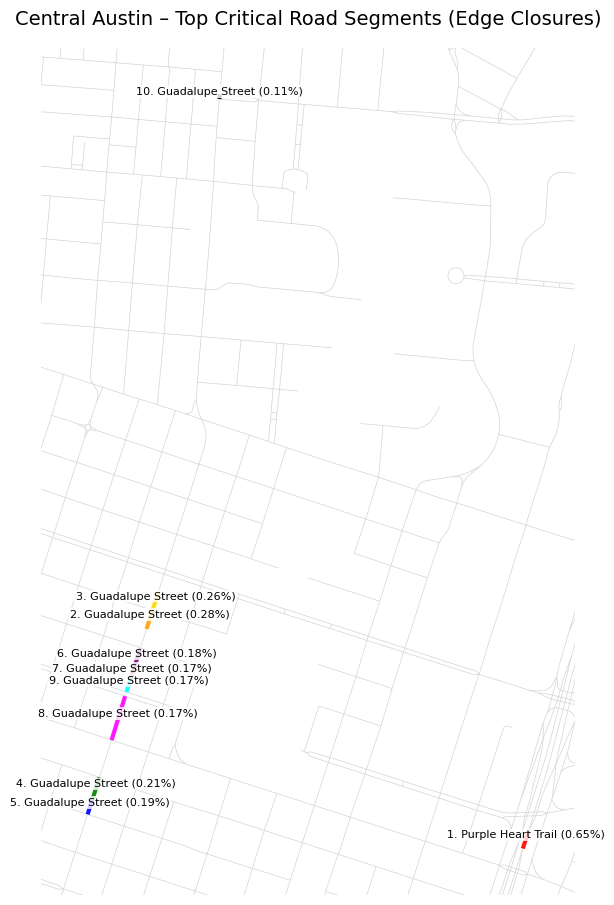

In [410]:
# ==========================
# Map: Top critical road segments (edges)
# ==========================

# Build line geometry for each critical edge
crit_edges = edge_impact_austin.copy()
crit_edges["geometry"] = crit_edges["edge"].apply(
    lambda uv: LineString([uv[0], uv[1]])
)

gdf_crit_edges = gpd.GeoDataFrame(
    crit_edges,
    geometry="geometry",
    crs="EPSG:3857"
)

fig, ax = plt.subplots(figsize=(11, 11))

# Background roads
roads_3857.plot(ax=ax, color="lightgray", linewidth=0.5)

# Give each segment a distinct-ish color by rank
colors = [
    "red", "orange", "gold", "green", "blue",
    "purple", "brown", "magenta", "cyan", "black"
]

gdf_crit_edges = gdf_crit_edges.sort_values("eff_drop_pct", ascending=False).reset_index(drop=True)
gdf_crit_edges["rank"] = gdf_crit_edges.index + 1
gdf_crit_edges["color"] = [
    colors[(r - 1) % len(colors)] for r in gdf_crit_edges["rank"]
]

for _, row in gdf_crit_edges.iterrows():
    # plot each critical edge
    gpd.GeoDataFrame([row], geometry="geometry", crs="EPSG:3857").plot(
        ax=ax,
        color=row["color"],
        linewidth=3,
        alpha=0.9
    )
    # label near the centroid
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    label = f"{row['rank']}. {row['road_name']} ({row['eff_drop_pct']:.2f}%)"
    ax.text(
        x, y,
        label,
        fontsize=8,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.0)
    )

# Zoom to area containing the critical edges
minx, miny, maxx, maxy = gdf_crit_edges.total_bounds
pad = 150
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Central Austin – Top Critical Road Segments (Edge Closures)", fontsize=14)
ax.set_axis_off()

plt.show()


### Robustness

In [412]:
# ==========================
# Helper: approximate efficiency from fixed node pairs
# ==========================

def approximate_efficiency_from_pairs(G, pairs, weight="travel_time_s"):
    """
    Approximate global efficiency using a fixed list of node pairs.
    """
    inv_d_sum = 0.0
    count = 0

    for u, v in pairs:
        if (u not in G) or (v not in G):
            continue
        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
            if d > 0:
                inv_d_sum += 1.0 / d
                count += 1
        except nx.NetworkXNoPath:
            continue

    return inv_d_sum / count if count > 0 else 0.0


In [419]:
# ==========================
# Failure curves: targeted vs random edges
# ==========================

SEED = 0

def simulate_failure_curves(
    G,
    edge_btw,
    max_remove=10,
    n_runs=10,
    n_pairs=400,
    weight="travel_time_s",
    seed=SEED,
):
    random.seed(seed)
    np.random.seed(seed)

    edges = sorted(G.edges())
    m = len(edges)
    max_remove = min(max_remove, m)

    # targeted order: highest edge betweenness first
    targeted_edges = [e for e, _ in sorted(edge_btw.items(),
                                           key=lambda x: x[1],
                                           reverse=True)]

    # sample node pairs once
    nodes = sorted(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    pairs = [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

    # baseline efficiency
    E0 = approximate_efficiency_from_pairs(G, pairs, weight=weight)

    # targeted removal curve
    G_tar = G.copy()
    E_targeted = [E0]
    for k in range(1, max_remove + 1):
        e = targeted_edges[k - 1]
        if G_tar.has_edge(*e):
            G_tar.remove_edge(*e)
        E_targeted.append(approximate_efficiency_from_pairs(G_tar, pairs, weight=weight))

    # random removal curves
    E_random_all = np.zeros((n_runs, max_remove + 1))
    for r in range(n_runs):
        G_rand = G.copy()
        order = edges.copy()
        np.random.shuffle(order)
        E_random_all[r, 0] = E0
        for k in range(1, max_remove + 1):
            e = order[k - 1]
            if G_rand.has_edge(*e):
                G_rand.remove_edge(*e)
            E_random_all[r, k] = approximate_efficiency_from_pairs(G_rand, pairs, weight=weight)

    E_random_mean = E_random_all.mean(axis=0)
    E_random_std = E_random_all.std(axis=0)
    ks = np.arange(0, max_remove + 1)

    return pd.DataFrame({
        "k_removed": ks,
        "E_targeted": E_targeted,
        "E_random_mean": E_random_mean,
        "E_random_std": E_random_std
    })

failure_curves_austin = simulate_failure_curves(
    G_main,
    edge_btw,
    max_remove=5,
    n_runs=10,
    n_pairs=1000,
    weight="travel_time_s",
    seed=SEED
)

failure_curves_austin.head()


,k_removed,E_targeted,E_random_mean,E_random_std
0,0,0.004034,0.004034,0.000000
1,1,0.004023,0.004034,0.000002
2,2,0.004023,0.004034,0.000003
3,3,0.004018,0.004032,0.000004
4,4,0.003996,0.004031,0.000004


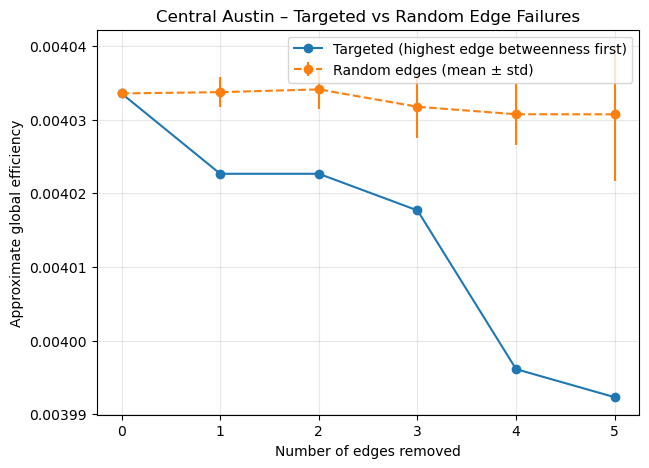

In [421]:
# ==========================
# Plot failure curves
# ==========================

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(
    failure_curves_austin["k_removed"],
    failure_curves_austin["E_targeted"],
    marker="o",
    label="Targeted (highest edge betweenness first)"
)

ax.errorbar(
    failure_curves_austin["k_removed"],
    failure_curves_austin["E_random_mean"],
    yerr=failure_curves_austin["E_random_std"],
    marker="o",
    linestyle="--",
    label="Random edges (mean ± std)"
)

ax.set_xlabel("Number of edges removed")
ax.set_ylabel("Approximate global efficiency")
ax.set_title("Central Austin – Targeted vs Random Edge Failures")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


## Question 3

In [424]:
import pandas as pd

# Corridor ranking for Austin:
# for each road_name, take the max eff_drop_pct among its segments
road_rank_austin = (
    edge_impact_austin
    .groupby("road_name", as_index=False)["eff_drop_pct"]
    .max()
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)

road_rank_austin.head(10)


,road_name,eff_drop_pct
0,Purple Heart Trail,0.653092
1,Guadalupe Street,0.284430


In [426]:
# --- Pick a disruption scenario: top-k critical roads by corridor ranking (Austin) ---

k_damage = 5  # e.g., close top 5 worst roads
top_damaged_roads_austin = road_rank_austin.head(k_damage)["road_name"].tolist()
print("Austin roads closed in disruption:", top_damaged_roads_austin)

# For each of those roads, close the edge with largest eff_drop_pct
damaged_edges_df_austin = (
    edge_impact_austin
    .sort_values("eff_drop_pct", ascending=False)
    .drop_duplicates(subset="road_name")  # one "most damaging" edge per road
)

damaged_edges_df_austin = damaged_edges_df_austin[
    damaged_edges_df_austin["road_name"].isin(top_damaged_roads_austin)
]

closed_edges_austin = damaged_edges_df_austin["edge"].tolist()
closed_edges_austin


Austin roads closed in disruption: ['Purple Heart Trail', 'Guadalupe Street']


[((-10879544.902299203, 3538429.4911985276),
  (-10879525.94458992, 3538485.5989117017)),
 ((-10880740.473630324, 3539198.483701402),
  (-10880759.631714689, 3539138.441336582))]

In [428]:
# Intact efficiency (you likely already computed this as base_eff)
E_intact = base_eff
print("Intact efficiency (Austin):", E_intact)

# Damaged network: remove the chosen edges
G_damaged_austin = G_main.copy()
G_damaged_austin.remove_edges_from(closed_edges_austin)

E_damaged = approx_global_efficiency(
    G_damaged_austin,
    weight="travel_time_s",
    k_sources=200,
    seed=0
)

print("Damaged efficiency (Austin):", E_damaged)

if E_intact > 0:
    damage_pct = 100 * (E_intact - E_damaged) / E_intact
    print(f"Total percent loss from disruption: {damage_pct:.2f}%")


Intact efficiency (Austin): 0.004258743128767823
Damaged efficiency (Austin): 0.004218824187398678
Total percent loss from disruption: 0.94%


In [430]:
from shapely.geometry import Point
import geopandas as gpd

def greedy_repair_order_edges_austin(G_intact, closed_edges, roads_gdf, max_steps=None):
    """
    Greedy repair strategy for Austin:
    - Start from a damaged graph (all closed_edges removed).
    - At each step, reopen the single edge that gives the largest
      percent gain in approximate global efficiency.
    """
    G_current = G_intact.copy()
    G_current.remove_edges_from(closed_edges)

    remaining = list(closed_edges)
    steps = max_steps if max_steps is not None else len(remaining)

    # starting efficiency (damaged)
    E_current = approx_global_efficiency(
        G_current,
        weight="travel_time_s",
        k_sources=200,
        seed=0
    )
    print("Starting efficiency (damaged):", E_current)

    records = []

    for step in range(1, steps + 1):
        best_gain = -1
        best_edge = None
        best_E_after = None

        # try reopening each remaining closed edge, one at a time
        for e in remaining:
            u, v = e
            if not G_intact.has_edge(u, v):
                continue  # safety check

            data = G_intact[u][v]

            # temporarily reopen this edge
            G_current.add_edge(u, v, **data)

            E_after = approx_global_efficiency(
                G_current,
                weight="travel_time_s",
                k_sources=200,
                seed=0
            )
            gain_pct = (E_after - E_current) / E_current * 100 if E_current > 0 else 0

            if gain_pct > best_gain:
                best_gain = gain_pct
                best_edge = e
                best_E_after = E_after

            # revert
            G_current.remove_edge(u, v)

        if best_edge is None:
            print("No more useful repairs found; stopping.")
            break

        # Permanently reopen best_edge
        u, v = best_edge
        G_current.add_edge(u, v, **G_intact[u][v])
        E_current = best_E_after

        # identify road name near the midpoint of the repaired edge
        midpoint = Point((u[0] + v[0]) / 2.0, (u[1] + v[1]) / 2.0)
        gdf_mid = gpd.GeoDataFrame(
            {"step": [step]},
            geometry=[midpoint],
            crs="EPSG:3857"
        )

        if road_name_col is not None:
            match = gpd.sjoin_nearest(
                gdf_mid,
                roads_gdf[[road_name_col, "geometry"]],
                how="left",
                distance_col="dist",
                max_distance=50
            ).iloc[0]
            if pd.notna(match[road_name_col]):
                road_name = match[road_name_col]
            else:
                road_name = "Unnamed road"
        else:
            road_name = "Unknown road"

        records.append({
            "step": step,
            "edge": best_edge,
            "road_name": road_name,
            "efficiency_after": best_E_after,
            "gain_pct": best_gain
        })

        remaining.remove(best_edge)
        print(f"Step {step}: reopen {road_name}, gain {best_gain:.2f}%")

    return pd.DataFrame(records)


In [434]:
repair_order_austin = greedy_repair_order_edges_austin(
    G_main,
    closed_edges_austin,
    roads_3857,
    max_steps=len(closed_edges_austin)
)


Starting efficiency (damaged): 0.004218824187398678
Step 1: reopen Purple Heart Trail, gain 0.66%
Step 2: reopen Guadalupe Street, gain 0.29%


In [432]:
repair_order_austin = greedy_repair_order_edges_austin(
    G_austin_main,
    closed_edges_austin,
    roads_3857,
    max_steps=len(closed_edges_austin)
)

repair_order_austin

Starting efficiency (damaged): 0.004218824187398678
Step 1: reopen Purple Heart Trail, gain 0.66%
Step 2: reopen Guadalupe Street, gain 0.29%


,step,edge,road_name,efficiency_after,gain_pct
0,1,"((-10879544.902299203, 3538429.4911985276), (-10879525.94458992, 3538485.5989117017))",Purple Heart Trail,0.004247,0.659089
1,2,"((-10880740.473630324, 3539198.483701402), (-10880759.631714689, 3539138.441336582))",Guadalupe Street,0.004259,0.285241
